In [31]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example with Different Losses')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100000, metavar='N',
                    help='how many batches to wait before logging training status')

_StoreAction(option_strings=['--log-interval'], dest='log_interval', nargs=None, const=None, default=100000, type=<class 'int'>, choices=None, help='how many batches to wait before logging training status', metavar='N')

In [32]:
args = parser.parse_known_args()[0]

In [33]:
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

In [34]:
device = torch.device("cuda" if args.cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

In [35]:
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=False,
#                    transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)

In [36]:
import numpy as np 
import pandas as pd 
import scanpy as sc
data=sc.read_h5ad("new_data.h5ad")
label=data.obs['label'].to_numpy()
newlabel=[]
for i in label:
    if i=="astrocytes_ependymal":
        newlabel.append(0)
    elif i=="endothelial-mural":
        newlabel.append(1)
    elif i=="interneurons":
        newlabel.append(2)
    elif i=="microglia":
        newlabel.append(3)
    elif i=="oligodendrocytes":
        newlabel.append(4)
    elif i=="pyramidal CA1":
        newlabel.append(5)
    else:
        newlabel.append(6)
source_data = data.X
source_label = np.array(newlabel).reshape(773,1)
# 将图像数据转为向量数据
train_data=torch.from_numpy(source_data)
train_label=torch.from_numpy(np.array(newlabel))

In [37]:
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=args.batch_size, shuffle=True, **kwargs)

In [38]:
train_loader

In [39]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 1.
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_original(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### 2. 
# using the loss function which only consider reconstruction term.
def loss_function_only_recon(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE

### 3. 
# be careful of the way two losses calculated.
# the only difference of this loss function is that the second term - KLD
# is "mean".
def loss_function_o1(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### 4.
def loss_function_o2(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='mean')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### 5.
def loss_function_kld(recon_x, x, mu, logvar):
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

### 6.
# apply the l1 loss
def loss_function_l1(recon_x, x, mu, logvar):
    L1 = F.l1_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return L1 + KLD

### 7.
# apply the MSE loss
def loss_function_l2(recon_x, x, mu, logvar):
    L1 = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return L1 + KLD

# def train(epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         which_loss = 7
        
#         if which_loss==1:
#             loss = loss_function_original(recon_batch, data, mu, logvar)
#         elif which_loss==2:
#             loss = loss_function_only_recon(recon_batch, data)
#         elif which_loss==3:
#             loss = loss_function_o1(recon_batch, data, mu, logvar)
#         elif which_loss==4:
#             loss = loss_function_o2(recon_batch, data, mu, logvar)
#         elif which_loss==5:
#             loss = loss_function_kld(recon_batch, data, mu, logvar)
#         elif which_loss==6:
#             loss = loss_function_l1(recon_batch, data, mu, logvar)
#         elif which_loss==7:
#             loss = loss_function_l2(recon_batch, data, mu, logvar)
            
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()

#     print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


# def test(epoch):
#     model.eval()
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             if (i == 0) and (epoch % 10 == 0):
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'vae_img/7_m_reconstruction_' + str(epoch) + '.png', nrow=n)

In [41]:
model.train()
train_loss = 0
for batch_idx, data in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    which_loss = 7
        
    if which_loss==1:
        loss = loss_function_original(recon_batch, data, mu, logvar)
    elif which_loss==2:
        loss = loss_function_only_recon(recon_batch, data)
    elif which_loss==3:
        loss = loss_function_o1(recon_batch, data, mu, logvar)
    elif which_loss==4:
        loss = loss_function_o2(recon_batch, data, mu, logvar)
    elif which_loss==5:
        loss = loss_function_kld(recon_batch, data, mu, logvar)
    elif which_loss==6:
        loss = loss_function_l1(recon_batch, data, mu, logvar)
    elif which_loss==7:
        loss = loss_function_l2(recon_batch, data, mu, logvar)
            
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

RuntimeError: shape '[-1, 784]' is invalid for input of size 585728

In [21]:
# 定义自编码网络edmodel
myedmodel = VAE().to(device)

In [22]:
from torchsummary import summary

summary(myedmodel, input_size=(1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                   [-1, 20]           8,020
            Linear-3                   [-1, 20]           8,020
            Linear-4                  [-1, 400]           8,400
            Linear-5                  [-1, 784]         314,384
Total params: 652,824
Trainable params: 652,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.49
Estimated Total Size (MB): 2.51
----------------------------------------------------------------


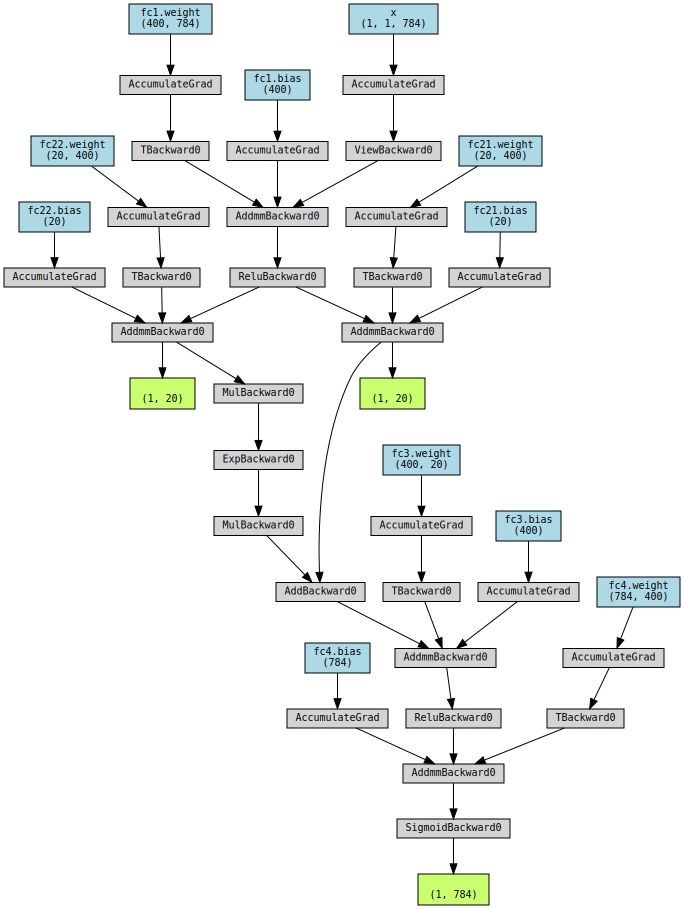

In [24]:
# 输出网络结构
from torchviz import make_dot

x = torch.randn(1, 1, 784).requires_grad_(True)
y = myedmodel(x.to(device))
myEDNet_vis = make_dot(y, params=dict(list(myedmodel.named_parameters()) + [('x', x)]))
myEDNet_vis

In [17]:
data.shape

torch.Size([96, 1, 28, 28])

In [19]:
_.shape

torch.Size([96])

In [20]:
train_loader

In [ ]:
if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        if epoch%10 == 0:
            with torch.no_grad():
                sample = torch.randn(64, 20).to(device)
                sample = model.decode(sample).cpu()
                save_image(sample.view(64, 1, 28, 28),
                        'vae_img/7_m_sample_' + str(epoch) + '.png')